In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy as cy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import s3fs
import intake
import warnings

In [110]:
def count_ARs(ds, lat_cut):
    '''
    Counts number of AR at each time step. Returns dataset with added coordinate ar_counts_[lat_cut].
    '''
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))

    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ll = xr.plot.contour(pole_ds.sel(time=ts).ivt, levels=[0.0,1.0])
        plt.close()
        if len(ll.collections)>1: #You can remove this and next line if you have run it a few times without getting the printout :))
            print('julia was wrong about something, tell her to fix it'+ts) 
        nr_ar = len(ll.collections[0].get_paths())
        ar_counts[i] = nr_ar
    ds[f'ar_counts_{lat_cut}']= (['time'], ar_counts)
    return ds

def circle_for_polar_map(axes):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_boundary(circle, transform=axes.transAxes)
    
def sort_ar_by_aod(aod_ds,ar_ds, poll_lim, clean_lim):
    warnings.simplefilter('ignore', UserWarning)
    aod_ar=aod_ds.where(ar_ds.ivt==True)
    aod_ar['poll_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    aod_ar['clean_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    aod_ar['mid_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    for ts in aod_ar.time:
        ts_array = aod_ar.sel(time=ts).od550aer
        ll = xr.plot.contourf(ts_array.squeeze(), levels=[0,20])
        plt.close()
        for i,item in enumerate(ll.collections[0].get_paths()):
            v = item.vertices
            lat = v[:,1]
            lon = v[:,0]
            ar_i_aod = ts_array.sel(lat=slice(np.min(lat), np.max(lat)), lon = slice(np.min(lon), np.max(lon)))
            if ar_i_aod.mean(skipna=True).values>poll_lim.values:
                aod_ar['poll_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
            elif ar_i_aod.mean(skipna=True).values< clean_lim.values :
                aod_ar['clean_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
            else:
                aod_ar['mid_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
    
    return aod_ar

## Load data

In [3]:
start_year='2000'
end_year='2015'

Historical aod

In [4]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
#s3.ls('escience2022/Remy/')

In [5]:
s3path_hist1_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20000101-20091231.nc'
s3path_hist2_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20100101-20141231.nc'

hist1_aod = xr.open_dataset(s3.open(s3path_hist1_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])
hist2_aod = xr.open_dataset(s3.open(s3path_hist2_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])

aod_hist = xr.merge([hist1_aod, hist2_aod])

Atmospheric river detection file

In [6]:
ar_hist = xr.open_dataset('20002015_AR_detection_counted.nc')

Variables

In [7]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [8]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['clt','pr','tas'], member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list = list(dset_dict.keys())
dset = dset_dict[dataset_list[0]]
hist_vars = dset.sel(member_id='r1i1p1f1',time=slice(str(start_year)+"-01-01", str(end_year)+"-01-01"))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## Calculating aod thresholds

[]

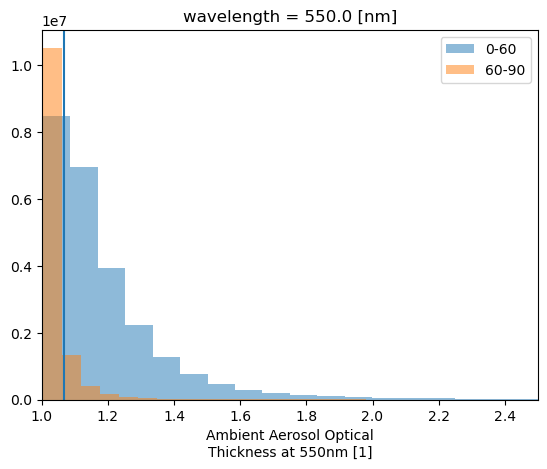

In [57]:
aod_hist.sel(lat = slice(0,60)).od550aer.plot.hist(bins=200, xlim = [1,2.5], label='0-60', alpha=0.5)
aod_hist.sel(lat = slice(60,90)).od550aer.plot.hist(bins=200, xlim = [1,2.5], label='60-90', alpha=0.5)
plt.axvline(aod_hist.sel(lat = slice(0,60)).od550aer.quantile(0.25))
plt.legend()
plt.plot()

In [96]:
aod_lim= {}
aod_lim['arc_75th'] = aod_hist.sel(lat = slice(60,90)).od550aer.quantile(0.75,skipna=True)
aod_lim['arc_25th'] = aod_hist.sel(lat = slice(60,90)).od550aer.quantile(0.25,skipna=True)
aod_lim['arc_50th'] = aod_hist.sel(lat = slice(60,90)).od550aer.quantile(0.25,skipna=True)
aod_lim['arc_mean'] = aod_hist.sel(lat = slice(60,90)).od550aer.mean(skipna=True)
aod_lim['arc_median'] = aod_hist.sel(lat = slice(60,90)).od550aer.median(skipna=True)
aod_lim['midlat_mean'] = aod_hist.sel(lat = slice(0,60)).od550aer.mean(skipna=True)
aod_lim['midlat_75th'] = aod_hist.sel(lat = slice(0,60)).od550aer.quantile(0.75,skipna=True)
aod_lim['midlat_25th'] = aod_hist.sel(lat = slice(0,60)).od550aer.quantile(0.25,skipna=True)
aod_lim['midlat_90th'] = aod_hist.sel(lat = slice(0,60)).od550aer.quantile(0.9,skipna=True)

In [111]:
aod_ar_ds = sort_ar_by_aod(aod_hist, ar_hist, aod_lim['midlat_75th'], aod_lim['midlat_25th'])

In [112]:
hist_poll_ar = hist_vars.sel(lat=slice(60,90)).where(aod_ar_ds.poll_ar_aod.notnull() )
hist_clean_ar = hist_vars.sel(lat=slice(60,90)).where(aod_ar_ds.clean_ar_aod.notnull() )

In [ ]:
plotting_vars = {}
vars = ['clt','pr','tas']
levs = ['clean','mid','poll']
for var in vars:
    for lev in levs:
        var = {}
         var[lev]= hist_clean_ar[var].values.flatten()[~np.isnan(hist_clean_ar[var].values.flatten())]
    
    

In [113]:
clean_clt = hist_clean_ar.clt.values.flatten()[~np.isnan(hist_clean_ar.clt.values.flatten())]
poll_clt = hist_poll_ar.clt.values.flatten()[~np.isnan(hist_poll_ar.clt.values.flatten())]

In [114]:
clean_tas = hist_clean_ar.tas.values.flatten()[~np.isnan(hist_clean_ar.tas.values.flatten())]
poll_tas = hist_poll_ar.tas.values.flatten()[~np.isnan(hist_poll_ar.tas.values.flatten())]

In [115]:
clean_pr = hist_clean_ar.pr.values.flatten()[~np.isnan(hist_clean_ar.pr.values.flatten())]
poll_pr = hist_poll_ar.pr.values.flatten()[~np.isnan(hist_poll_ar.pr.values.flatten())]

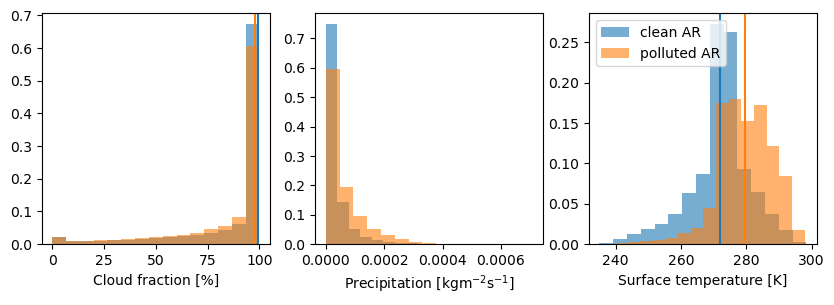

In [128]:
fig, axs = plt.subplots(1,3, dpi=100, figsize=(10,3))

axs[0].hist(clean_clt, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_clt) + 1. / clean_clt.size)
axs[0].hist(poll_clt,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_clt) + 1. / poll_clt.size)
axs[0].axvline(np.median(clean_clt), color= 'tab:blue')
axs[0].axvline(np.median(poll_clt), color= 'tab:orange')

axs[1].hist(clean_pr, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_pr) + 1. / clean_pr.size)
axs[1].hist(poll_pr,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_pr) + 1. / poll_pr.size)
#axs[1].axvline(np.mean(clean_pr), color= 'tab:blue')
#axs[1].axvline(np.mean(poll_pr), color= 'tab:orange')

axs[2].hist(clean_tas, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_tas) + 1. / clean_tas.size)
axs[2].hist(poll_tas,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_tas) + 1. / poll_tas.size)
axs[2].axvline(np.mean(clean_tas), color= 'tab:blue')
axs[2].axvline(np.mean(poll_tas), color= 'tab:orange')

axs[0].set_xlabel('Cloud fraction [%]')
axs[1].set_xlabel('Precipitation [kgm$^{-2}$s$^{-1}$]')
axs[2].set_xlabel('Surface temperature [K]')

#axs[0].set_yscale('log')
#axs[1].set_yscale('log')
plt.legend()
plt.show()

In [ ]:
#Seasonal plot
#add hus
#bias correction
#continue automation